# Run Expectancy, Run Production, and RE24

We have computed the run expectancy matrix for a year.  What can this tell us about run production performance?  How good is a batter at producing runs or helping the team produce runs?  RBI is a direct computation of produced runs but it misses so much (among other issues).  We also want to factor in a notion of a productive plate appearances that do not necessarily lead to runs but improve the likely scoring of runs.  For example, a single with the bases empty or a double with a runner on first who subsequently moves to third.

So instead of just computing something simple like RBI, how can we get a possible improved measure of run production?
We compute the change in run potential plus the actual runs produced (RBI).  But what is run potential?  If the bases are loaded with no outs, the run potential intuitively is very high.  Any plate appearnacne outcome should factor in that the run potential was already so high.  An out in this situation should be a very negative play.  A single that leaves the bases loaded should be equal to 1 run (the state of the base runners or outs did not change).  And so forth.

More generally, we use run expectancy of the number of outs and base runner state as the run potential and we take the change in run potential as the run expectancy of _next_ plate appearance minus the un expectancy of current plate appearance.

Thus, the run production value is,
$$
    \mbox{RunValue}_i = \mbox{RunPotential}_{i+1} - \mbox{RunPotential}_{i} + \mbox{RunsScored}_{i}
$$
This is the stat RE24 on Fangraphs.  (Caveat: Since RE24 requires a run expectancy matrix, Fangraphs actually uses a park specific run expectancy matrix, not a "global" matrix.) See: https://www.fangraphs.com/library/misc/re24/

What does this tell us?  If a plate appearance's value is positive, the plate appearance was productive in expectation.  If it is negative, the plate appearance was not so productive in expectation.  With this measure of productivity, we can explore batter or pitcher performance or other aspects of run production.

#### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
year = 2002

In [3]:
base_runner_codes = {
    0: "OOO", # No one on
    1: "XOO", # runner on 1st
    2: "OXO", # runner on 2nd
    3: "XXO", # runners on 1st & 2nd
    4: "OOX", # runner on 3d
    5: "XOX", # runners on 1st & 3rd
    6: "OXX", # runners on 2nd & 3rd
    7: "XXX"  # bases loaded
}

## I. Load Data

We load the events data and the run expectancy matrix.  

### I.1 Load Events

We only need a subset of the columns:
+ `EVENT_ID`
+ `BAT_ID` - Player ID for the batter
+ `BAT_LINEUP_ID` - Lineup position of the batter
+ `BAT_EVENT_FL` - A 0-1 flag indicating whether the event was a plate appearance or not
+ `OUTS_CT` - Number of outs at the start of the event
+ `EVENT_RUNS_CT` - Number of runs scored during the event
+ `EVENT_OUTS_CT` - Number of outs recorded during the event
+ `START_BASES_CD` - Base runner state at the start of the event
+ `END_BASES_CD` - Base runner state at the end of the event

In [4]:
usecols = ['EVENT_ID', 'BAT_ID', 'BAT_LINEUP_ID', 'BAT_EVENT_FL', 'OUTS_CT',
           'EVENT_RUNS_CT', 'EVENT_OUTS_CT', 'START_BASES_CD', 'END_BASES_CD']
events = pd.read_csv('../data/mlb_pxp/csv/events-{}.csv.gz'.format(year), usecols=usecols)

# We want a mask so we can restrict to just batting events for now (so no balks)
bat_mask = (events['BAT_EVENT_FL'] == "T")
events = events.loc[bat_mask].copy()

events['START_BASES_CD'].replace(base_runner_codes, inplace=True)
events['END_BASES_CD'].replace(base_runner_codes, inplace=True)
events.head(5)

,OUTS_CT,BAT_ID,BAT_LINEUP_ID,BAT_EVENT_FL,EVENT_OUTS_CT,EVENT_ID,START_BASES_CD,END_BASES_CD,EVENT_RUNS_CT
0,0,lawtm002,1,T,0,1,OOO,XOO,0
1,0,vizqo001,2,T,0,2,XOO,OXO,1
2,0,burke001,3,T,0,3,OXO,XOX,0
3,0,thomj002,4,T,0,4,XOX,XXO,1
4,0,frymt001,5,T,0,5,XXO,XXX,0


### I.2 Load Run Expectancy

In [5]:
re = pd.read_csv(
    '../data/mlb_pxp/re/re-{}.csv'.format(year),
    index_col=['outs', 'base_runners'],
    squeeze=True
)
re.unstack(level=0)

outs,0,1,2
base_runners,,,
OOO,0.518993,0.275218,0.101632
OOX,1.398374,0.941866,0.364173
OXO,1.155332,0.691038,0.324555
OXX,1.970992,1.366449,0.632308
XOO,0.903826,0.540536,0.228197
XOX,1.850844,1.203285,0.533108
XXO,1.517082,0.944760,0.458772
XXX,2.316005,1.518538,0.773804


## II. Computing Run Potential

For every plate appearance, we extract the run potential given the outs and base runner state.  We also extract the run potential of the next plate appearance using `END_BASES_CD` as well as `OUTS_CT` + `EVENT_OUTS_CT`.

In [6]:
idx = list(zip(events['OUTS_CT'], events['START_BASES_CD']))  # Build current out-runner states
events['RUN_POT'] = re.loc[idx].values                        # Extract run potentials

next_outs = events['OUTS_CT'] + events['EVENT_OUTS_CT']
idx = list(zip(next_outs, events['END_BASES_CD']))            # Build next out-runner states
events['RUN_POT_NEXT'] = re.loc[idx].values                   # Extract run potentials

# When the inning ends, there are 3 outs.  That is not in the run expectancy matrix 
# so inning ending plate appearances will have an NA value here.  We fill those with 0.
events['RUN_POT_NEXT'].fillna(0, inplace=True)

In [7]:
events[['RUN_POT', 'RUN_POT_NEXT']].head(5)

,RUN_POT,RUN_POT_NEXT
0,0.518993,0.903826
1,0.903826,1.155332
2,1.155332,1.850844
3,1.850844,1.517082
4,1.517082,2.316005


## III. Compute Run Production Value

Using the formula above, we can now compute the run production value of the events.

In [8]:
events['RUN_VALUE'] = events['RUN_POT_NEXT'] - events['RUN_POT'] + events['EVENT_RUNS_CT']

In [9]:
events[['RUN_VALUE']].head(5)

,RUN_VALUE
0,0.384833
1,1.251506
2,0.695513
3,0.666238
4,0.798924


## IV. Let's Explore!

### IV.1 Collect Batter Data

We first group by `BAT_ID` and add up all the run potentials and run production values.

In [10]:
batter_data = events.groupby('BAT_ID')['RUN_POT', 'RUN_VALUE'].sum()

We want to augment this with the following:
+ Number of plate appearances
+ Run potential per plate appearance
+ Run production value per plate appearance

In [11]:
pa_ct = events.groupby('BAT_ID')['EVENT_ID'].count()

# A mask for when we want to restrict to batters with many plate appearances
qualified = pa_ct >= 400

batter_data['PA_CT'] = pa_ct

batter_data['RUN_POT_PER_PA'] = batter_data['RUN_POT'] / pa_ct
batter_data['RUN_VALUE_PER_PA'] = batter_data['RUN_VALUE'] / pa_ct

We want to compute some other interesting measures.

+ `RUN_CONV_PCT` - Percentage of run potential is converted to run production
+ `RUN_POT_SF` - How far below run potential is the run production. SF stands for shortfall.  
+ `RUN_POT_SF_PER_PA` - How far below run potential is the run production per plate appearance.

In [12]:
batter_data['RUN_CONV_PCT'] = batter_data['RUN_VALUE'] / batter_data['RUN_POT']
batter_data['RUN_POT_SF'] = batter_data['RUN_POT'] - batter_data['RUN_VALUE']
batter_data['RUN_POT_SF_PER_PA'] = batter_data['RUN_POT_SF'] / pa_ct

Finally, we compute the most common lineup position for each batter.

In [13]:
def most_common_element(s):
    return s.value_counts().index[0]

batter_data['lineup_pos'] = events.groupby('BAT_ID')['BAT_LINEUP_ID'].apply(most_common_element)

#### The Batter Data!

Looks like Barry Bonds' 2001 season had an absurd amount of run production!

In [14]:
batter_data.sort_values('RUN_VALUE', ascending=False).head(10)

,RUN_POT,RUN_VALUE,PA_CT,RUN_POT_PER_PA,RUN_VALUE_PER_PA,RUN_CONV_PCT,RUN_POT_SF,RUN_POT_SF_PER_PA,lineup_pos
BAT_ID,,,,,,,,,
bondb001,296.328502,116.227664,612,0.484197,0.189914,0.392226,180.100838,0.294282,3
berkl001,344.103966,71.388431,692,0.497260,0.103162,0.207462,272.715535,0.394098,3
thomj002,325.072918,70.158543,613,0.530298,0.114451,0.215824,254.914375,0.415847,4
giamj001,358.116727,68.914544,689,0.519763,0.100021,0.192436,289.202182,0.419742,3
ramim002,277.696289,67.221247,518,0.536093,0.129771,0.242068,210.475042,0.406322,4
gileb002,320.354765,64.748181,644,0.497445,0.100541,0.202114,255.606584,0.396905,3
rodra001,357.670189,60.797410,725,0.493338,0.083858,0.169982,296.872780,0.409480,3
walkl001,283.836144,59.861320,553,0.513266,0.108248,0.210901,223.974824,0.405018,3
heltt001,357.556834,57.599865,668,0.535265,0.086227,0.161093,299.956970,0.449037,4


### IV.2 What can we ask?

How much does run potential impact your ability to produce runs?  Meaning, is it context dependent or not?  (Hint: it is.)  How much does run potential depend on lineup position?  How about run production?

#### (A) What is the relationship between run potential and run production?

We look at run potential and run production on a scatter plot.  The relationship we observe is fairly clear.  As total run potential increases, ie. the hitter is hitting in a more "run rich" environment, run production tends to increase.  This makes sense in two ways:
+ On the one hand, if we think everyone is an average batter, then being exposed to higher run potential would obviously lead to high run production. 
+ On the other hand, all batters are not equal and we expect that managers are smart enough to place their best run producing batters in positions with high run potential.  So of course better hitters who produce more runs also have high run potential.

An important ramification for this is it is it may or may not be appropriate to view total run production without contextualization.  That is, without considering the total run potential, a players total run production may or may not be as informative as you think it is.

On the whole, a high level of run production is without question and could serve as the basis of an MVP vote.  In terms of estimating a talent level, without even considering whether this is in fact a repeatable skill, total run production is not a good measure.

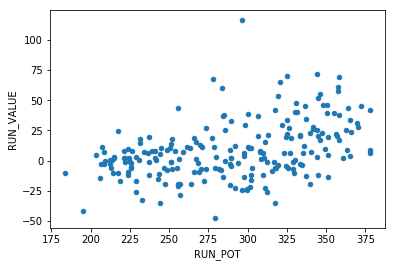

In [15]:
batter_data.loc[qualified].plot.scatter(x='RUN_POT', y='RUN_VALUE');

#### (B) How does lineup position affect run potential (and therefore run production)?

We just saw there is a relationship between total run potential and total run production.  We now ask, how does this relate to the lineup order?  We already know strong hitters bat higher in the lineup.  What more can we infer from the data about this?

In [16]:
bat_order_totals = events.groupby('BAT_LINEUP_ID')['RUN_POT', 'RUN_VALUE'].sum()
bat_order_totals

,RUN_POT,RUN_VALUE
BAT_LINEUP_ID,,
1,11277.208796,-144.025192
2,11190.840070,-63.846071
3,10835.348565,923.929251
4,11153.151214,867.514220
5,11014.986773,154.334741
6,10501.035518,-39.510208
7,10116.891192,-286.351343
8,9780.436381,-517.801717
9,9334.683696,-1187.004550


##### An Odd Finding...
Interesting: total run potential is very high for the first 4 position in the lineup and then falls off.  Yet, total run production peaks at the 3rd and 4th position in the lineup.  If the leadoff hitter has one of the highest total run potentials, why is the best hitter not hitting first?

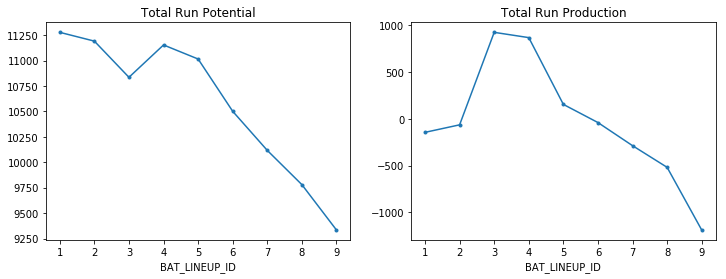

In [17]:
fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
bat_order_totals['RUN_POT'].plot(ax=axarr[0], marker='.', title='Total Run Potential')
bat_order_totals['RUN_VALUE'].plot(ax=axarr[1], marker='.', title='Total Run Production');

##### ...Easily Explained
It turns out, there is an obvious and natural decline in the total number of plate appearances as you move down the batting lineup.  The leadoff hitter has a high total run potential because leadoff hitters have the most plate appearances!  This is why accumulation/counting stats can be so deceiving.

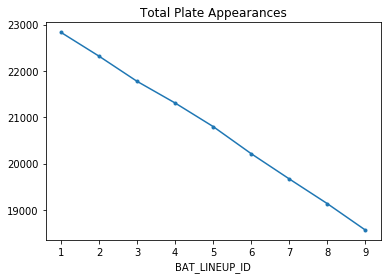

In [18]:
bat_order_counts = events.groupby('BAT_LINEUP_ID')['EVENT_ID'].count()
bat_order_counts.plot(marker='.', title='Total Plate Appearances');

##### Normalize by Number of PAs

When we normalize by the number of plate appearances, we see clearly now that the 4th and 5th hitters clearly bat in the most run rich environments.  However, the hitters with the highest run production per plate appearance bat 3rd.

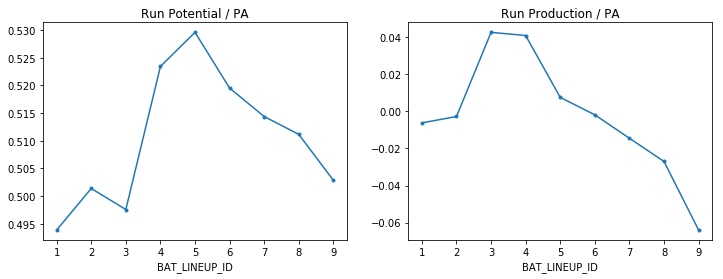

In [19]:
bat_order_avgs = events.groupby('BAT_LINEUP_ID')['RUN_POT', 'RUN_VALUE'].mean()
fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
bat_order_avgs['RUN_POT'].plot(ax=axarr[0], marker='.', title='Run Potential / PA')
bat_order_avgs['RUN_VALUE'].plot(ax=axarr[1], marker='.', title='Run Production / PA');

##### Batters by Lineup Position

We have the most common lineup position for each batter.  To compare to our average performance across the lineup above, let's look at how performance varies among hitters by lineup position.  We restrict to "qualifying" hitters with at least 400 PAs.

There is a fair amount of variability among the batters!  Even though the 4th spot is on average the most run rich position, some 4 hitters batted in relatively very run poor situations.  

Run production is a similar story: the overall trend is the same as above but the extent of variation in performance is quite large.  Actually, one issue with 2001 is that Barry Bonds was so incredible that his run production skews the boxplot for the No. 3 hitters.  His run production per PA is about 0.17 which the next best No. 3 (and next best overall) is Jason Giambi at 0.13.  That is a huge gap (~25%) when you compare to how close the other hitters are.

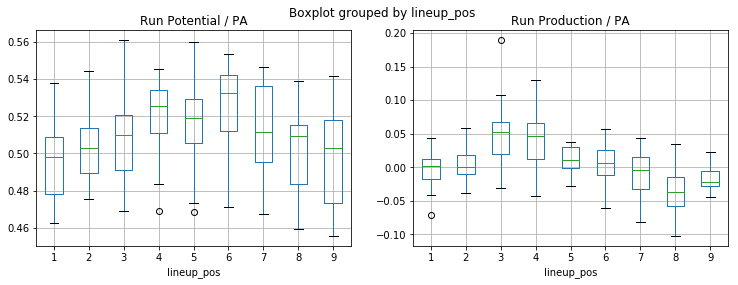

In [20]:
fig, axarr = plt.subplots(ncols=2, figsize=(12, 4))
# Use the mask qualified to ignore hitters who didn't play much.  They just create noise.
batter_data.loc[qualified].boxplot(ax=axarr[0], by='lineup_pos', column='RUN_POT_PER_PA')
batter_data.loc[qualified].boxplot(ax=axarr[1], by='lineup_pos', column='RUN_VALUE_PER_PA')
axarr[0].set_title('Run Potential / PA');
axarr[1].set_title('Run Production / PA');

#### (C) Revisiting the relationship between run potential and run production?

We return to run potential and run production.  We know now that accounting for number of plate appearances is important.  We also know lineup position is important.  

First, what about the relationship between run potential per PA and run production per PA?  Below, we see a scatter plot that shows, compare to the previous one, the relationship appears to be gone.

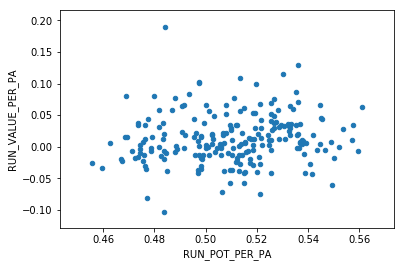

In [21]:
batter_data.loc[qualified].plot.scatter(x='RUN_POT_PER_PA', y='RUN_VALUE_PER_PA');

##### But wait...
Didn't we _just_ see that batters in the middle of the order tend to have higher run potential per PA _and_ higher run production per PA?

Let's group the hitters by their lineup position.  We know the lineup position relates to the two values but what about within the groups?

The takeaways may not be obvious but here they are:
1. As with the above boxplots, some of the lineup positions (#3 and #4, for example) have elevated levels run production.
2. Run potential is also variable across the lineup positions as we saw before.
2. However, within each group there does not appear to be any relationship between run potential per PA and run production per PA.  If there were a real relationship, we should see the regression lines all or mostly sloping upward as run potential per PA increases.  Instead, the regression lines are not consistent in direction.  Also, the confidence bands, which give regions where the real relationship lines might be, are wide and encompass the flat, horizontal line.  The means we have little to no evidence so far there is in fact a relationship.

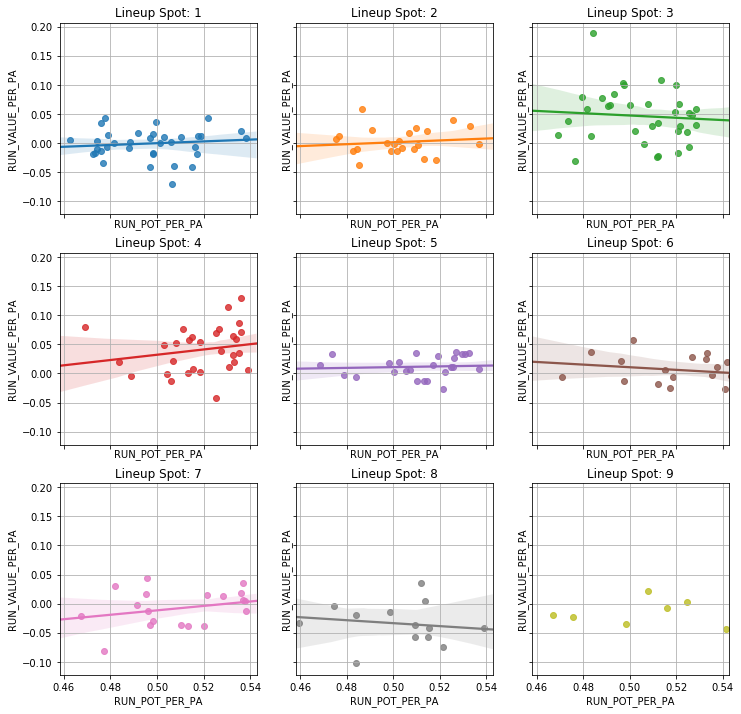

In [22]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
grps = batter_data.loc[qualified].groupby('lineup_pos')
for i, (pos, grp) in enumerate(grps):
    ax = axarr.ravel()[i]
    sns.regplot(
        ax=ax,
        x='RUN_POT_PER_PA', y='RUN_VALUE_PER_PA',
        data=grp, 
        fit_reg=(i != 8),
        robust=True,   # Use bootstrap to estimate confidence region for regression
        n_boot=100
    )
    ax.grid()
    ax.set_title("Lineup Spot: %d" % pos)

## V. Summary

Here's a quick summary of what this notebook did:
1. We computed the RE24 stat for each batter using the run expectancy matrix.
2. We saw that Bonds had a great 2001 year.  Duh. But to put this into broader context, we need a different analysis across many years.  His was the first season a batter had an RE24 above 100 and he was far above.  His seasons 2001, 2002, and 2004 are the only ones ever over 100.
3. We saw there is an obvious relationship between total run potential and total run production.  This relationship is due to number of plate appearances.  This is part of the curse of counting style statistics.  More oppotunities lead to improved statistics.
4. And finally, we saw that different spots in the lineup have different run potential and hitters in those spots have different run production levels.  But within a lineup spot, there is so far little evidence there is a relationship between run potential per PA and run production per PA.

###### What would help take this analysis further?  

First, we could gather more years (we do have them).  However, we need to account for the league wide variability in offense.  Not doing so can and likely will dramatically muddy results.  The boxplots showing the variability of run potential across the lineup can be become very misleading if weak offensive seasons are combined with strong offensive seasons.  If that happens, an effect we expect to be present will be masked and any conclusions we wish to make will potentially be invalid.  There are two other aspects of the data that we need to account for: park affects and difference in play between leagues.

Second, we should also investigate whether run production per PA is a repeatable skill.  That means we should look year-to-year to see if batters can repeat performance or if there is a large element of randomness/luck.